In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
#from torch.utils.tensorboard import SummaryWriter # TensorBoard support
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
import time
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
from IPython.display import clear_output
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

#### Las cosas que vamos a variar son:
- Funcion de activacion: vamos a variar entre ReLU y Leaky ReLU
- Dropout: vamos a usar p=0.1 y p=0.3
- Optimizador: vamos a usar ADAM y SGD

In [2]:
#Como siempre chequeamos que este el GPU o el CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [3]:
# Cargamos los datos de FASHION-MNIST
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [55]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self,p=0.1):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    
    
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    
    self.dropout = nn.Dropout(p)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = self.dropout(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = self.dropout(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [56]:
model = Network().to(device)
print(model)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [58]:
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el progreso...
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_samples += y.size(0)            
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [60]:
# Definimos hiperparámetros de entrenamiento
learning_rate = 1e-3
batch_size = 1000
num_epochs = 100
num_k = 1 #72
n=10 # Recordar que 28*28=784
dropouts=[0.1,0.3,0.5]
# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()
# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.
for p in dropouts:
#for k in range(num_k):
    # Creamos el modelo y el optimzador
    model = Network(p)
    # Creamos los dataloaders ...
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    # ... en particular, usamos el dataset de prueba (test) como dataset de validación
    valid_dataloader = DataLoader(test_dataset,batch_size=batch_size)         
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
    # Entrenamos el modelo y calcualmos curvas.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataloader,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataloader,model,loss_fn)
        valid_loss,valid_accu = test_loop(valid_dataloader,model,loss_fn)
        print(f"n={n} p={p} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"n":n,
                        "p":p,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu,
                        "valid_loss":valid_loss,
                        "valid_accu":valid_accu}
                        ,ignore_index=True)
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

n=10 p=0.1 epoch=0 train_loss=0.8500287334124247 train_accu=0.6877666666666666 valid_loss=0.864807802438736 valid_accu=0.684
n=10 p=0.1 epoch=1 train_loss=0.6948346416155498 train_accu=0.73495 valid_loss=0.7132699728012085 valid_accu=0.7292
n=10 p=0.1 epoch=2 train_loss=0.6310261984666189 train_accu=0.7567666666666667 valid_loss=0.6497359275817871 valid_accu=0.7509
n=10 p=0.1 epoch=3 train_loss=0.5853830521305402 train_accu=0.7768833333333334 valid_loss=0.6044900238513946 valid_accu=0.7689
n=10 p=0.1 epoch=4 train_loss=0.5507020577788353 train_accu=0.79415 valid_loss=0.5703883707523346 valid_accu=0.7833
n=10 p=0.1 epoch=5 train_loss=0.5209681098659833 train_accu=0.8065666666666667 valid_loss=0.5422378063201905 valid_accu=0.7965
n=10 p=0.1 epoch=6 train_loss=0.4975489467382431 train_accu=0.8167166666666666 valid_loss=0.5199748277664185 valid_accu=0.8059
n=10 p=0.1 epoch=7 train_loss=0.47849336365858713 train_accu=0.8248833333333333 valid_loss=0.5017484813928604 valid_accu=0.8138
n=10 p=

In [85]:
print(df)

          n    k  epoch  train_loss  train_accu  valid_loss  valid_accu    p
0    2048.0  0.0      0    0.324914    0.879900    0.358151      0.8712  NaN
1    2048.0  0.0      1    0.318141    0.882533    0.351912      0.8740  NaN
2    2048.0  0.0      2    0.312732    0.884967    0.347244      0.8755  NaN
3    2048.0  0.0      3    0.307159    0.886817    0.343223      0.8769  NaN
4    2048.0  0.0      4    0.302259    0.888633    0.339378      0.8781  NaN
..      ...  ...    ...         ...         ...         ...         ...  ...
469    10.0  NaN     95    0.181258    0.932333    0.323428      0.8945  0.5
470    10.0  NaN     96    0.183912    0.931067    0.327432      0.8939  0.5
471    10.0  NaN     97    0.182319    0.931750    0.328123      0.8941  0.5
472    10.0  NaN     98    0.181189    0.932433    0.328949      0.8938  0.5
473    10.0  NaN     99    0.179308    0.933333    0.328593      0.8937  0.5

[474 rows x 8 columns]


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n           425 non-null    float64
 1   k           174 non-null    float64
 2   epoch       474 non-null    int64  
 3   train_loss  474 non-null    float64
 4   train_accu  474 non-null    float64
 5   valid_loss  474 non-null    float64
 6   valid_accu  474 non-null    float64
 7   p           300 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 29.8 KB


In [90]:
len(df)

474

In [86]:
%%bash --out list_json
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.json

In [76]:
list_json = list_json.split()
list_json

['simulation-results-2022-02-20-01-13-58.json',
 'simulation-results-2022-02-20-01-15-42.json',
 'simulation-results-2022-02-20-01-22-58.json',
 'simulation-results-2022-02-20-01-29-25.json',
 'simulation-results-2022-02-20-01-46-31.json',
 'simulation-results-2022-02-20-13-26-42.json',
 'simulation-results-2022-02-20-14-30-21.json',
 'simulation-results-2022-02-20-14-39-32.json',
 'simulation-results-2022-02-20-15-05-27.json',
 'simulation-results-2022-02-20-15-18-25.json',
 'simulation-results-2022-02-20-15-25-11.json',
 'simulation-results-2022-02-20-16-10-09.json',
 'simulation-results-2022-02-20-18-06-20.json']

In [77]:
df = pd.concat([pd.read_json(json_fname) for json_fname in list_json],ignore_index=True)
df

,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu,p
0,2048.0,0.0,0,0.324914,0.879900,0.358151,0.8712,NaN
1,2048.0,0.0,1,0.318141,0.882533,0.351912,0.8740,NaN
2,2048.0,0.0,2,0.312732,0.884967,0.347244,0.8755,NaN
3,2048.0,0.0,3,0.307159,0.886817,0.343223,0.8769,NaN
4,2048.0,0.0,4,0.302259,0.888633,0.339378,0.8781,NaN
...,...,...,...,...,...,...,...,...
469,10.0,NaN,95,0.181258,0.932333,0.323428,0.8945,0.5
470,10.0,NaN,96,0.183912,0.931067,0.327432,0.8939,0.5
471,10.0,NaN,97,0.182319,0.931750,0.328123,0.8941,0.5
472,10.0,NaN,98,0.181189,0.932433,0.328949,0.8938,0.5


In [100]:
df9 = df.drop(df.index[0:174],0)
df9

/tmp/ipykernel_4305/4179297450.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df9 = df.drop(df.index[0:174],0)


,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu,p
174,10.0,NaN,0,0.850029,0.687767,0.864808,0.6840,0.1
175,10.0,NaN,1,0.694835,0.734950,0.713270,0.7292,0.1
176,10.0,NaN,2,0.631026,0.756767,0.649736,0.7509,0.1
177,10.0,NaN,3,0.585383,0.776883,0.604490,0.7689,0.1
178,10.0,NaN,4,0.550702,0.794150,0.570388,0.7833,0.1
...,...,...,...,...,...,...,...,...
469,10.0,NaN,95,0.181258,0.932333,0.323428,0.8945,0.5
470,10.0,NaN,96,0.183912,0.931067,0.327432,0.8939,0.5
471,10.0,NaN,97,0.182319,0.931750,0.328123,0.8941,0.5
472,10.0,NaN,98,0.181189,0.932433,0.328949,0.8938,0.5


In [101]:
df9.iloc[99]

n             10.000000
k                   NaN
epoch         99.000000
train_loss     0.200473
train_accu     0.924783
valid_loss     0.320957
valid_accu     0.892100
p              0.100000
Name: 273, dtype: float64

In [80]:
df1 = df.drop("n",1)
df1

/tmp/ipykernel_4305/956571061.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1 = df.drop("n",1)


,k,epoch,train_loss,train_accu,valid_loss,valid_accu,p
0,0.0,0,0.324914,0.879900,0.358151,0.8712,NaN
1,0.0,1,0.318141,0.882533,0.351912,0.8740,NaN
2,0.0,2,0.312732,0.884967,0.347244,0.8755,NaN
3,0.0,3,0.307159,0.886817,0.343223,0.8769,NaN
4,0.0,4,0.302259,0.888633,0.339378,0.8781,NaN
...,...,...,...,...,...,...,...
469,NaN,95,0.181258,0.932333,0.323428,0.8945,0.5
470,NaN,96,0.183912,0.931067,0.327432,0.8939,0.5
471,NaN,97,0.182319,0.931750,0.328123,0.8941,0.5
472,NaN,98,0.181189,0.932433,0.328949,0.8938,0.5


In [81]:
df2 = df1.pivot_table(index=["epoch"],aggfunc="count").reset_index()
df2

,epoch,k,p,train_accu,train_loss,valid_accu,valid_loss
0,0,12,3,15,15,15,15
1,1,12,3,15,15,15,15
2,2,10,3,13,13,13,13
3,3,10,3,13,13,13,13
4,4,10,3,13,13,13,13
...,...,...,...,...,...,...,...
95,95,1,3,4,4,4,4
96,96,1,3,4,4,4,4
97,97,1,3,4,4,4,4
98,98,1,3,4,4,4,4


In [82]:
df3 = df1.pivot_table(index=["epoch"],aggfunc="mean").reset_index()
df3

,epoch,k,p,train_accu,train_loss,valid_accu,valid_loss
0,0,0.0,0.3,0.789876,0.564979,0.781433,0.594581
1,1,0.0,0.3,0.820467,0.474930,0.810980,0.506263
2,2,0.0,0.3,0.844522,0.412610,0.833646,0.446886
3,3,0.0,0.3,0.852082,0.394191,0.839823,0.429650
4,4,0.0,0.3,0.858094,0.380431,0.845500,0.416974
...,...,...,...,...,...,...,...
95,95,0.0,0.3,0.930258,0.186333,0.893850,0.320144
96,96,0.0,0.3,0.930342,0.185880,0.893925,0.321446
97,97,0.0,0.3,0.930583,0.185210,0.894150,0.321978
98,98,0.0,0.3,0.931229,0.184161,0.894100,0.322091


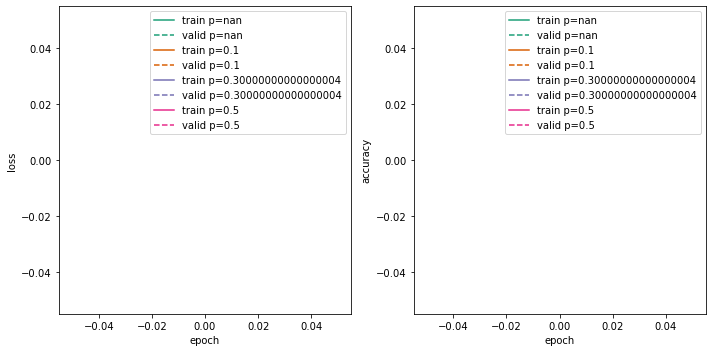

In [83]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color,p in zip(colors,df["p"].unique()):
    dfn = df3[df3["p"]==p]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"train p={p}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"valid p={p}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,dfn["train_accu"],label=f"train p={p}",color=color)
    ax.plot(x,dfn["valid_accu"],label=f"valid p={p}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()    

In [103]:
df9 = df9.drop("k",1)
df9

/tmp/ipykernel_4305/1740212885.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df9 = df9.drop("k",1)


,epoch,train_loss,train_accu,valid_loss,valid_accu,p
174,0,0.850029,0.687767,0.864808,0.6840,0.1
175,1,0.694835,0.734950,0.713270,0.7292,0.1
176,2,0.631026,0.756767,0.649736,0.7509,0.1
177,3,0.585383,0.776883,0.604490,0.7689,0.1
178,4,0.550702,0.794150,0.570388,0.7833,0.1
...,...,...,...,...,...,...
469,95,0.181258,0.932333,0.323428,0.8945,0.5
470,96,0.183912,0.931067,0.327432,0.8939,0.5
471,97,0.182319,0.931750,0.328123,0.8941,0.5
472,98,0.181189,0.932433,0.328949,0.8938,0.5


In [104]:
df10 = df9.pivot_table(index=["epoch"],aggfunc="count").reset_index()
df10

,epoch,p,train_accu,train_loss,valid_accu,valid_loss
0,0,3,3,3,3,3
1,1,3,3,3,3,3
2,2,3,3,3,3,3
3,3,3,3,3,3,3
4,4,3,3,3,3,3
...,...,...,...,...,...,...
95,95,3,3,3,3,3
96,96,3,3,3,3,3
97,97,3,3,3,3,3
98,98,3,3,3,3,3


In [105]:
df11 = df9.pivot_table(index=["epoch"],aggfunc="mean").reset_index()
df11

,epoch,p,train_accu,train_loss,valid_accu,valid_loss
0,0,0.3,0.668528,0.895194,0.667300,0.907979
1,1,0.3,0.744039,0.666361,0.740333,0.684108
2,2,0.3,0.769833,0.591377,0.764133,0.608447
3,3,0.3,0.788406,0.548727,0.779167,0.566208
4,4,0.3,0.802994,0.518249,0.793367,0.536692
...,...,...,...,...,...,...
95,95,0.3,0.929072,0.189726,0.895033,0.311553
96,96,0.3,0.928989,0.189741,0.895267,0.313254
97,97,0.3,0.929089,0.189211,0.895433,0.314080
98,98,0.3,0.929711,0.187853,0.895267,0.314502


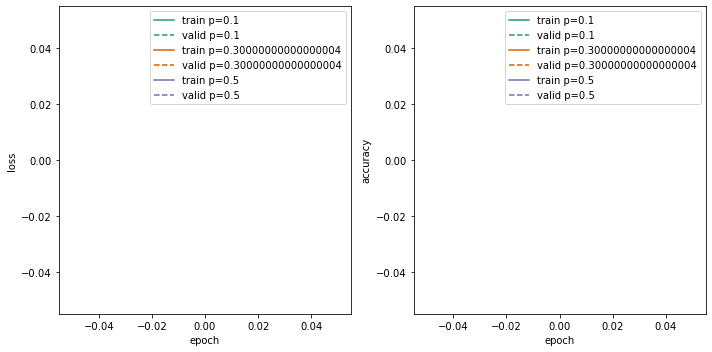

In [110]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color,p in zip(colors,df9["p"].unique()):
    df11 = df11[df11["p"]==p]
    x = df11["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,df11["train_loss"],label=f"train p={p}",color=color)
    ax.plot(x,df11["valid_loss"],label=f"valid p={p}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,df11["train_accu"],label=f"train p={p}",color=color)
    ax.plot(x,df11["valid_accu"],label=f"valid p={p}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()    